In [125]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

In [126]:
df = pd.read_csv('coding_round_data.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [129]:
# The dataset does not contain any nan values
selection = pd.isnull(df).sum(axis=0)>0
print (selection)

Administrative             False
Administrative_Duration    False
Informational              False
Informational_Duration     False
ProductRelated             False
ProductRelated_Duration    False
BounceRates                False
ExitRates                  False
PageValues                 False
SpecialDay                 False
Month                      False
OperatingSystems           False
Browser                    False
Region                     False
TrafficType                False
VisitorType                False
Weekend                    False
Revenue                    False
dtype: bool


In [130]:
# Pop target
target = df.pop('Revenue')

In [133]:
num_col = ['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues','SpecialDay']
num_df = df[num_col]
cat_df = df.loc[:,~df.columns.isin(num_col)]
# cat_df = pd.concat([df.loc[:,~df.columns.isin(num_col)]],axis = 1)
# cat_df.drop(labels, axis, index, columns, level, inplace., errors)

In [135]:
cat_df.nunique(dropna=False)

Month               10
OperatingSystems     8
Browser             13
Region               9
TrafficType         20
VisitorType          3
Weekend              2
dtype: int64

In [136]:
#print counts of each categorical variable
for col in cat_df:
    print(cat_df[col].value_counts(dropna=False),'\n')

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64 

2    6601
1    2585
3    2555
4     478
8      79
6      19
7       7
5       6
Name: OperatingSystems, dtype: int64 

2     7961
1     2462
4      736
5      467
6      174
10     163
8      135
3      105
13      61
7       49
12      10
11       6
9        1
Name: Browser, dtype: int64 

1    4780
3    2403
4    1182
2    1136
6     805
7     761
9     511
8     434
5     318
Name: Region, dtype: int64 

2     3913
1     2451
3     2052
4     1069
13     738
10     450
6      444
8      343
5      260
11     247
20     198
9       42
7       40
15      38
19      17
14      13
18      10
16       3
12       1
17       1
Name: TrafficType, dtype: int64 

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64 

False    9462
True     2868
Name: Weekend, dtype: int64 



In [112]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier


# from sklearn.linear_model import RandomForestRe
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [14]:
# We first run linear regression with only the numerical variables
X_train, X_test, y_train, y_test = train_test_split(num_df,
                                  target,
                                  test_size=0.2,
                                  random_state=1)

In [137]:
# scale numerical data
# scale numerical data
X_train_s = (num_df_train-num_df_train.min())/(num_df_train.max()-num_df_train.min())
X_test_s = (num_df_test-num_df_train.min())/(num_df_train.max()-num_df_train.min())

In [138]:
X_train_scaled

,0,1,2,3,4,5,6,7,8,9
0,-0.695075,-0.457171,-0.396532,-0.248563,-0.621633,-0.562207,-0.458434,0.143270,-0.321857,-0.309779
1,-0.695075,-0.457171,-0.396532,-0.248563,-0.688681,-0.615738,3.663888,3.230346,-0.321857,-0.309779
2,-0.695075,-0.457171,-0.396532,-0.248563,-0.688681,-0.615738,3.663888,3.230346,-0.321857,-0.309779
3,1.102885,0.149714,-0.396532,-0.248563,-0.465186,-0.537861,-0.343925,-0.062535,-0.321857,-0.309779
4,0.803225,-0.194332,-0.396532,-0.248563,-0.331089,-0.502758,-0.229417,-0.428411,-0.321857,-0.309779
...,...,...,...,...,...,...,...,...,...,...
9859,0.503565,1.784028,-0.396532,-0.248563,-0.576934,-0.401874,-0.458434,-0.628500,-0.321857,-0.309779
9860,0.203905,0.404829,3.520343,1.468349,0.249998,0.962344,-0.458434,-0.645650,-0.142292,-0.309779
9861,-0.395415,-0.397820,-0.396532,-0.248563,0.384095,0.283530,0.111674,0.102401,-0.321857,0.696033
9862,-0.095755,-0.245204,-0.396532,-0.248563,0.853434,2.670379,-0.114908,-0.313806,-0.321857,-0.309779


In [140]:
#Setup recursive feature reduction w/ cross validation
clf2 = RFECV(LogisticRegression(max_iter=200),
      scoring = 'roc_auc',
      n_jobs = -1,
      cv = 3,
      step = 1)

In [141]:
#Generate predicted probabilites for features without NAN
clf2.fit(X_train_s, y_train)

clf2_probs = clf2.predict_proba(X_test_s)
print('AUC: ', roc_auc_score(y_test, clf2_probs[:,1]))

AUC:  0.8862540663959102


In [145]:
reg = LogisticRegression()
reg.fit(X_train_s,y_train)
reg_probs = reg.predict_proba(X_test_s)
print('AUC: ', roc_auc_score(y_test, reg_probs[:,1]))

AUC:  0.8862769661824037


In [146]:
# Then we build a model with all features
X_train, X_test, y_train, y_test = train_test_split(df,
                                  target,
                                  test_size=0.2,
                                  random_state=1)

In [147]:
num_col = ['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues','SpecialDay']
num_df_train = X_train[num_col]
num_df_test = X_test[num_col]
cat_df_train = X_train.loc[:,~X_train.columns.isin(num_col)]
cat_df_test = X_test.loc[:,~X_test.columns.isin(num_col)]

In [149]:
# create dummy variables for trainining set
month_dummy = pd.get_dummies(cat_df_train['Month'])
visitor_dummy = pd.get_dummies(cat_df_train['VisitorType'])
weekend_dummy = pd.get_dummies(cat_df_train['Weekend'])
cat_df_train.drop(['Month','VisitorType','Weekend'],axis = 1, inplace = True)

cat_df_train = pd.concat([cat_df_train,month_dummy,visitor_dummy,weekend_dummy],axis = 1)

# create dummy variables for test set
month_dummy = pd.get_dummies(cat_df_test['Month'])
visitor_dummy = pd.get_dummies(cat_df_test['VisitorType'])
weekend_dummy = pd.get_dummies(cat_df_test['Weekend'])
cat_df_test.drop(['Month','VisitorType','Weekend'],axis = 1, inplace = True)

cat_df_test = pd.concat([cat_df_test,month_dummy,visitor_dummy,weekend_dummy],axis = 1)

C:\Users\xli22\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [150]:
# scale numerical data
X_train_s = (num_df_train-num_df_train.min())/(num_df_train.max()-num_df_train.min())
X_test_s = (num_df_test-num_df_train.min())/(num_df_train.max()-num_df_train.min())

In [151]:
# Concatenate numerical and categorical features
X_train_processed = pd.concat([X_train_s, cat_df_train], axis = 1)
X_test_processed = pd.concat([X_test_s, cat_df_test], axis = 1)

In [155]:
X_train_processed.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Mar,May,Nov,Oct,Sep,New_Visitor,Other,Returning_Visitor,False,True
3339,0.000000,0.000000,0.0,0.0,0.005674,0.001626,0.000000,0.250000,0.0,0.0,...,0,1,0,0,0,0,0,1,1,0
10953,0.000000,0.000000,0.0,0.0,0.001418,0.000000,1.000000,1.000000,0.0,0.0,...,0,0,0,0,0,0,0,1,1,0
8536,0.000000,0.000000,0.0,0.0,0.001418,0.000000,1.000000,1.000000,0.0,0.0,...,0,0,1,0,0,0,0,1,1,0
7766,0.230769,0.031590,0.0,0.0,0.015603,0.002365,0.027778,0.200000,0.0,0.0,...,0,0,1,0,0,0,0,1,1,0
8280,0.192308,0.013682,0.0,0.0,0.024113,0.003431,0.055556,0.111111,0.0,0.0,...,0,0,0,0,0,0,0,1,1,0


In [156]:
#Setup recursive feature reduction w/ cross validation
clf2 = RFECV(LogisticRegression(max_iter=1000),
      scoring = 'roc_auc',
      n_jobs = -1,
      cv = 3,
      step = 1)

In [157]:
#Generate predicted probabilites for features without NAN
clf2.fit(X_train_processed, y_train)

clf2_probs = clf2.predict_proba(X_test_processed)
print('AUC: ', roc_auc_score(y_test, clf2_probs[:,1]))

C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


AUC:  0.8939497417038788


C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [159]:
lr_col = X_train_processed.columns[clf2.support_]
print (lr_col)
print (len(lr_col))

Index(['Informational', 'Informational_Duration', 'ProductRelated',
       'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues',
       'Aug', 'Feb', 'Jul', 'Nov', 'Oct', 'Sep', 'New_Visitor'],
      dtype='object')
14


In [177]:
X_train_lr = X_train_processed[lr_col]
X_test_lr = X_test_processed[lr_col]
lr = LogisticRegression()
lr.fit(X_train_lr, y_train)
lr_probs = lr.predict_proba(X_test_lr)
print('AUC: ', roc_auc_score(y_test, lr_probs[:,1]))

AUC:  0.8939497417038788


In [181]:
lr.coef_[0]

array([ 0.67459019,  0.43177587,  1.41985024,  1.63210963, -0.73768509,
       -3.37008015, 17.87232294,  0.3842422 , -1.12142963,  0.55513077,
        0.95223051,  0.55176282,  0.47160928,  0.32458768])

<BarContainer object of 14 artists>

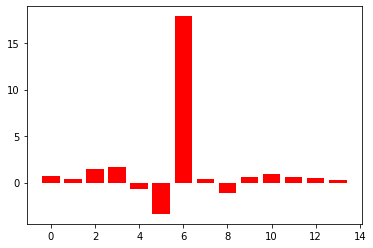

In [182]:
plt.bar(range(len(lr.coef_[0])), lr.coef_[0], color="r", align = "center")

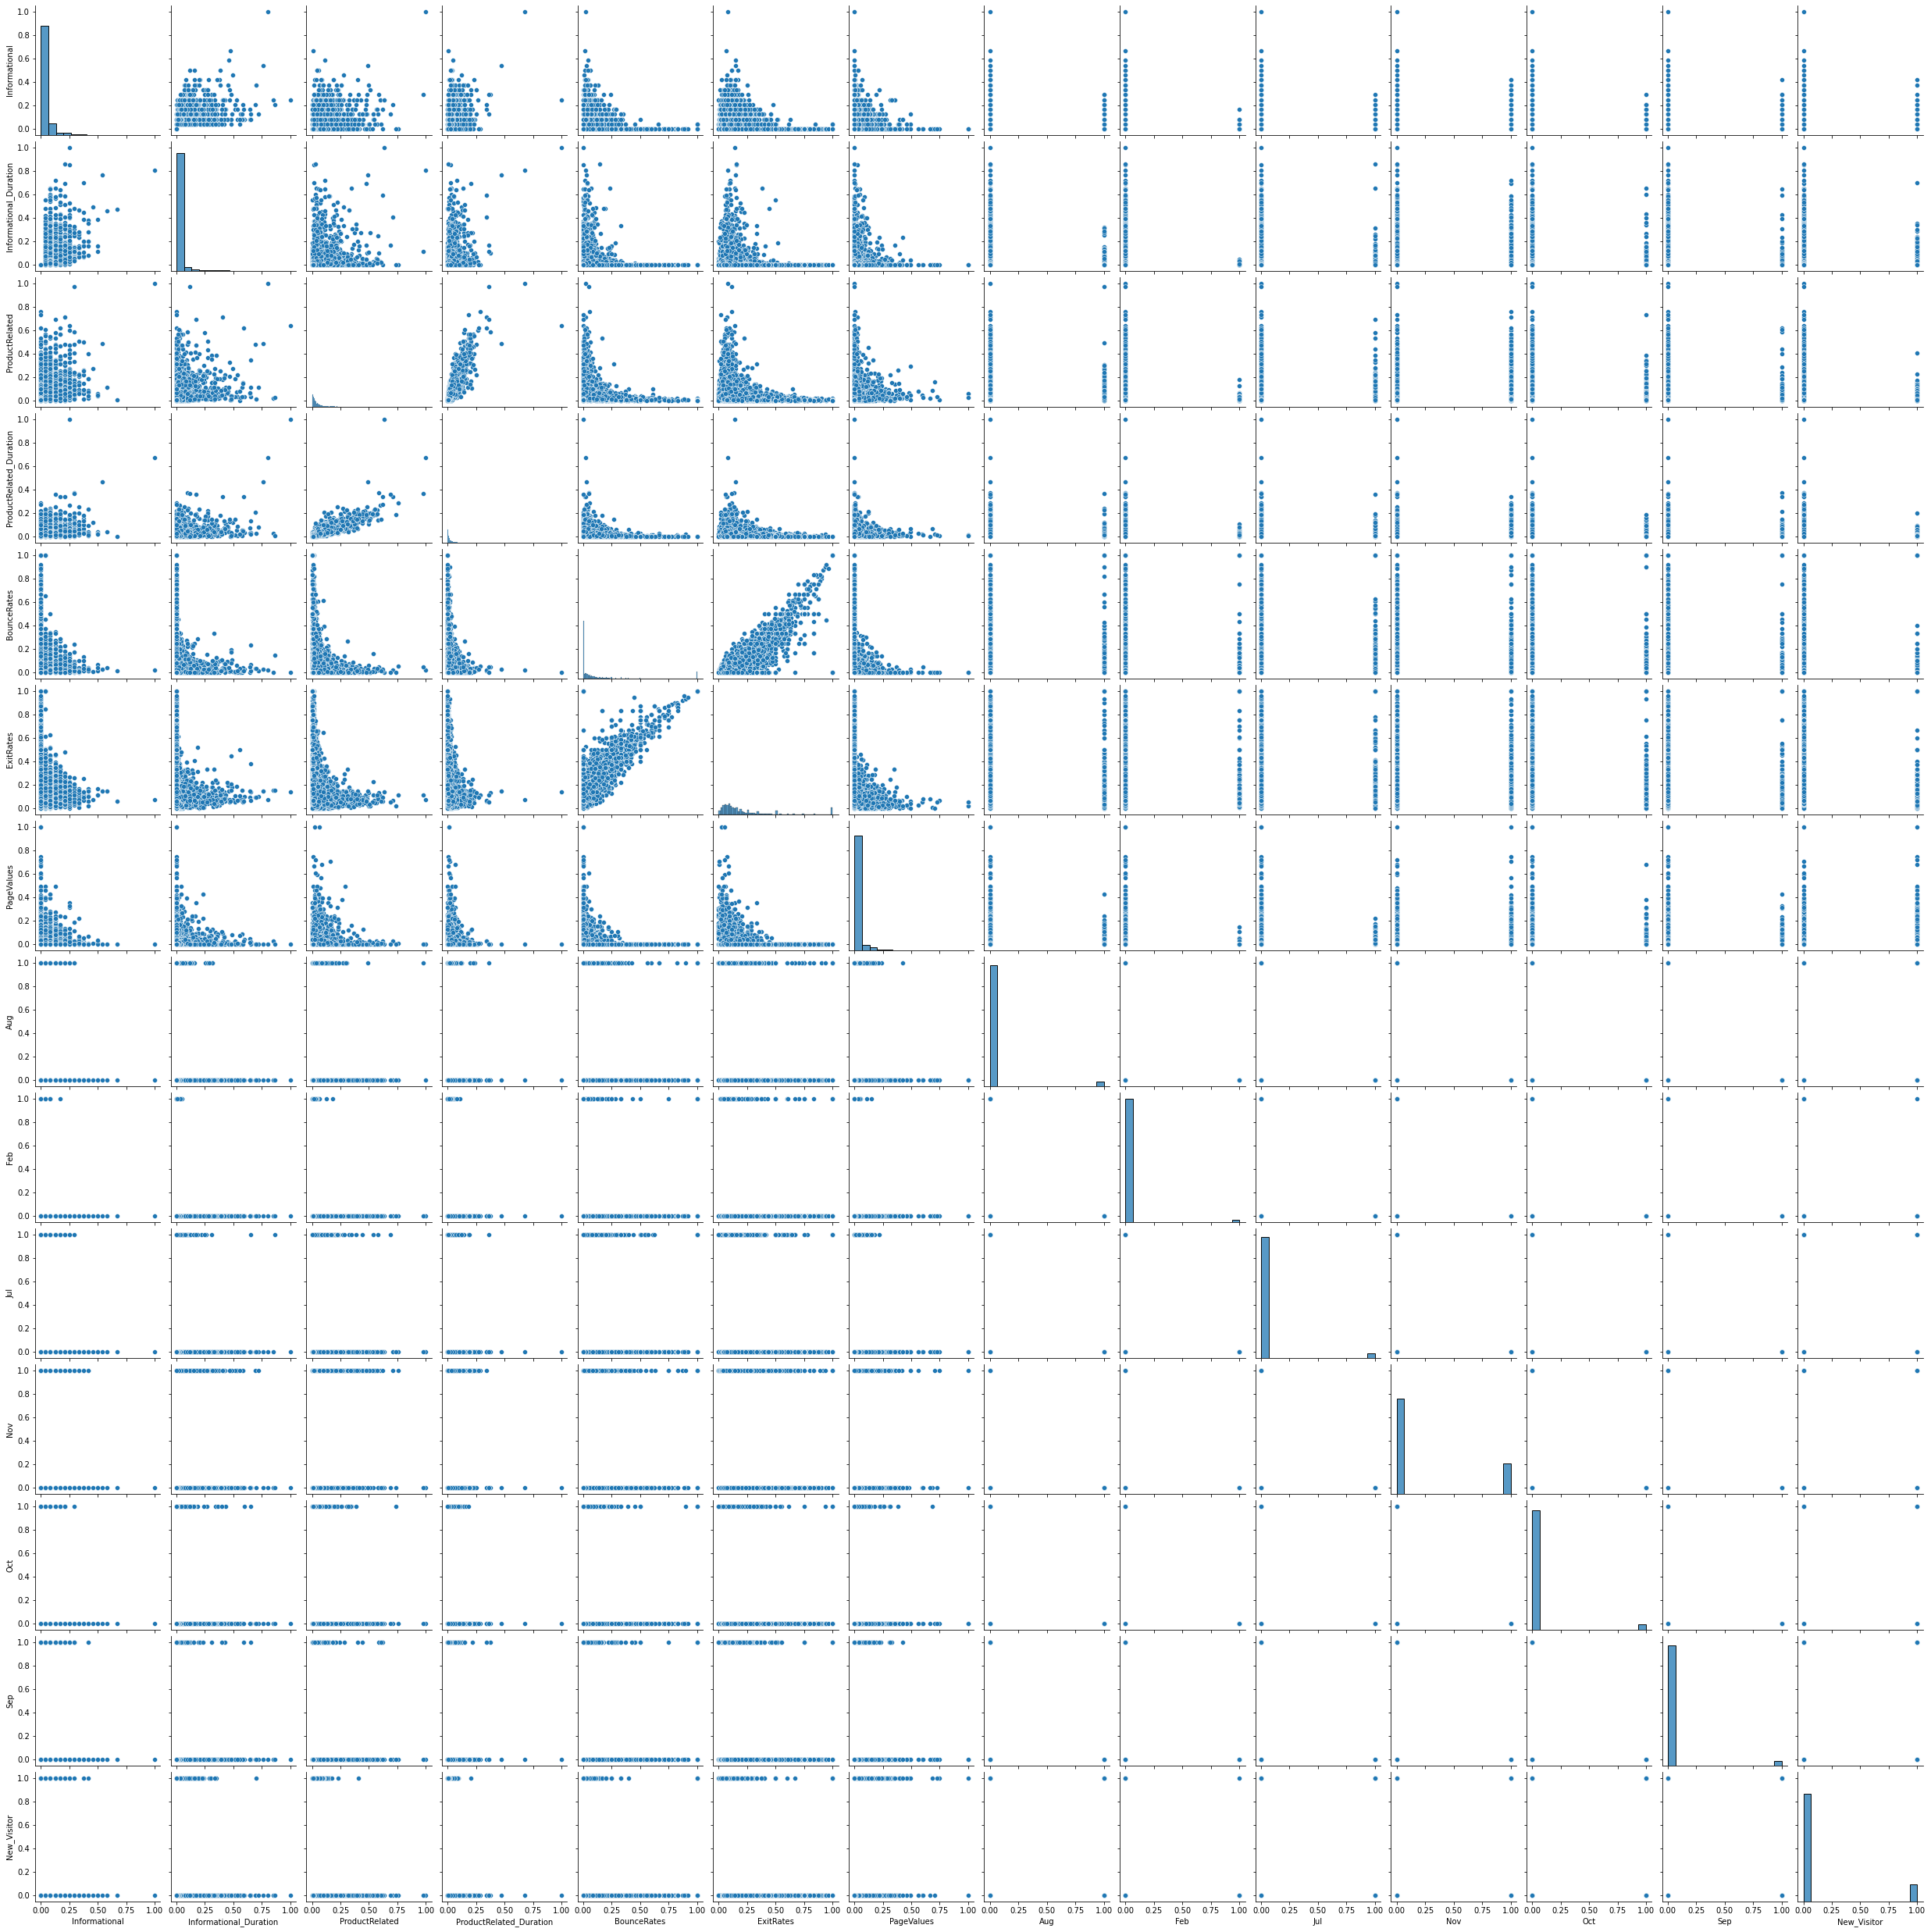

In [184]:
sns.pairplot(X_train_lr)

In [160]:
# RandomForestRegressor
#Setup recursive feature reduction w/ cross validation
clf2 = RFECV(RandomForestClassifier(),
      scoring = 'roc_auc',
      n_jobs = -1,
      cv = 3,
      step = 1)

In [161]:

clf2.fit(X_train_processed, y_train)

clf2_probs = clf2.predict_proba(X_test_processed)
print('AUC: ', roc_auc_score(y_test, clf2_probs[:,1]))

C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


AUC:  0.9332720427283075


C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [162]:
clf2.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True])

In [164]:
rf_col = X_train_processed.columns[clf2.support_]
print (rf_col)
print (len(rf_col))

Index([         'Administrative', 'Administrative_Duration',
                 'Informational',  'Informational_Duration',
                'ProductRelated', 'ProductRelated_Duration',
                   'BounceRates',               'ExitRates',
                    'PageValues',              'SpecialDay',
              'OperatingSystems',                 'Browser',
                        'Region',             'TrafficType',
                           'Aug',                     'Dec',
                           'Jul',                     'Mar',
                           'May',                     'Nov',
                           'Oct',                     'Sep',
                   'New_Visitor',       'Returning_Visitor',
                           False,                      True],
      dtype='object')
26


In [167]:
X_train_rf = X_train_processed.loc[:,clf2.support_]
X_test_rf = X_test_processed.loc[:,clf2.support_]

In [170]:
rf = RandomForestClassifier()
rf.fit(X_train_rf, y_train)
rf_probs = rf.predict_proba(X_test_rf)
print('AUC: ', roc_auc_score(y_test, rf_probs[:,1]))

C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


AUC:  0.9358428805237315


C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


<BarContainer object of 26 artists>

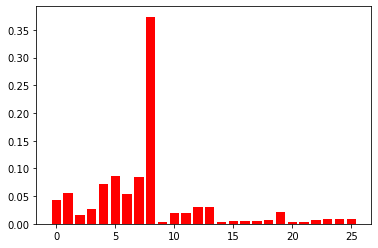

In [171]:
# Speed through water and draft forward are the most important features in random forest model.
importances = rf.feature_importances_
plt.bar(range(len(importances)), importances, color="r", align = "center")

In [173]:
rf_col[8]

'PageValues'

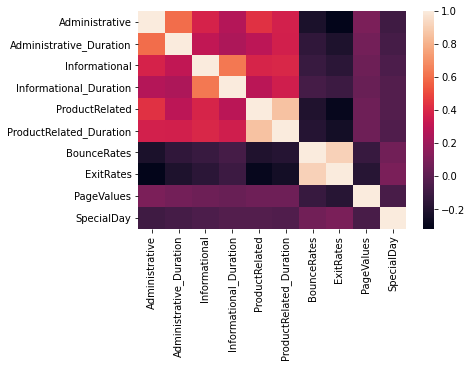

In [185]:
# By observing the colinearity heat map, we found that Administrative and Administrative are highly correlated. Informational and Informational duration are correlated. Product related and product related duration are correlated. Bounce rate and exit rates are correlated.
# So we would keep only one feature for each pair.
sns.heatmap(X_train_s.corr());

In [186]:
X_train_col = X_train_s.drop(['Administrative','Informational','ProductRelated','BounceRates'],axis = 1)
X_test_col = X_test_s.drop(['Administrative','Informational','ProductRelated','BounceRates'],axis = 1)

In [189]:
# Concatenate numerical and categorical features
X_train_remove_colinear = pd.concat([X_train_col, cat_df_train], axis = 1)
X_test_remove_colinear = pd.concat([X_test_col, cat_df_test], axis = 1)

In [192]:
# Logistic regression with non-colinear features
reg = LogisticRegression()
reg.fit(X_train_remove_colinear, y_train)
reg_probs = reg.predict_proba(X_test_remove_colinear)
print('AUC: ', roc_auc_score(y_test, reg_probs[:,1]))

AUC:  0.8873586443326396


C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\xli22\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn

<BarContainer object of 6 artists>

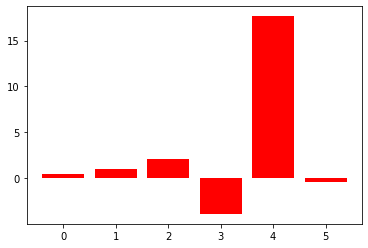

In [200]:
plt.bar(range(len(reg.coef_[0][0:6])), reg.coef_[0][0:6], color="r", align = "center")

In [201]:
X_train_col.columns

Index(['Administrative_Duration', 'Informational_Duration',
       'ProductRelated_Duration', 'ExitRates', 'PageValues', 'SpecialDay'],
      dtype='object')

In [202]:
# Logistic regression with non-colinear features
rf_non_colinear = RandomForestClassifier()
rf_non_colinear.fit(X_train_remove_colinear, y_train)
rf_non_colinear_probs = rf_non_colinear.predict_proba(X_test_remove_colinear)
print('AUC: ', roc_auc_score(y_test, rf_non_colinear_probs[:,1]))

C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


AUC:  0.9325762933327946


C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


<BarContainer object of 6 artists>

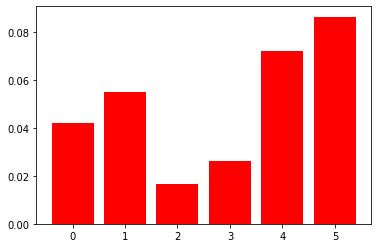

In [203]:
# Speed through water and draft forward are the most important features in random forest model.
importances = rf.feature_importances_
plt.bar(range(len(importances[0:6])), importances[0:6], color="r", align = "center")